In [ ]:
!wget https://dl.dropboxusercontent.com/s/unjllviexkxcfa6/phase_1.zip?dl=0
!mv phase_1.zip?dl=0 ph.zip
!unzip ph.zip
!wget https://dl.dropboxusercontent.com/s/u79uyn8hwmjm6ch/phase_2.zip?dl=0
!mv phase_2.zip?dl=0 ph2.zip
!unzip ph2.zip

--2022-04-23 09:34:06--  https://dl.dropboxusercontent.com/s/unjllviexkxcfa6/phase_1.zip?dl=0
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.81.15, 2620:100:6030:15::a27d:500f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.81.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52290331 (50M) [application/zip]
Saving to: ‘phase_1.zip?dl=0’

phase_1.zip?dl=0    100%[===================>]  49.87M  13.1MB/s    in 4.1s    

2022-04-23 09:34:11 (12.3 MB/s) - ‘phase_1.zip?dl=0’ saved [52290331/52290331]

Archive:  ph.zip
   creating: phase_1/
  inflating: phase_1/exp1-train-2000neg.bin  
  inflating: phase_1/exp1-train-400pos.bin  
  inflating: phase_1/exp1-train-neg.png  
  inflating: phase_1/exp1-train-pos.png  
  inflating: phase_1/exp12-test-1200.bin  
--2022-04-23 09:34:12--  https://dl.dropboxusercontent.com/s/u79uyn8hwmjm6ch/phase_2.zip?dl=0
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com).

In [13]:
import numpy as np
from sklearn import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import *
from sklearn.pipeline import *
from sklearn.preprocessing import *
import matplotlib.pyplot as plt
import time as time
import pandas as pd
from sklearn.svm import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import *
from sklearn.feature_selection import SelectKBest, chi2,f_classif
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import *
from scipy.stats import *
import seaborn as sns
#IDEAS AS FUCKOOOOO https://ieeexplore.ieee.org/document/9693921
#BAND POWER https://raphaelvallat.com/bandpower.html

In [14]:
#Recuperation des données 
donnees_positive_train = np.fromfile('./phase_1/exp1-train-400pos.bin', dtype=np.float32).reshape([400, 5, 768])
donnees_negative_train = np.fromfile('./phase_1/exp1-train-2000neg.bin', dtype=np.float32).reshape([2000, 5, 768])

donnees_positive_train2 = np.fromfile('./phase_2/exp2-train-400pos.bin', dtype=np.float32).reshape([400, 5, 768])
donnees_negative_train2 = np.fromfile('./phase_2/exp2-train-2000neg.bin', dtype=np.float32).reshape([2000, 5, 768])


donnees_test = np.fromfile('./phase_1/exp12-test-1200.bin', dtype=np.float32).reshape([1200, 5, 768])
donnees_test2 = np.fromfile('./phase_2/exp12-test-1200.bin', dtype=np.float32).reshape([1200, 5, 768])


train_ds = np.vstack([donnees_positive_train, donnees_positive_train2, donnees_negative_train, donnees_negative_train2])
train_labels = np.zeros(4800)
train_labels[:800] = 1
train_labels = train_labels.ravel()

In [15]:
def evaluation(model, X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    
    print(model.score(X_test,y_test))
    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()
    return model
    

In [16]:
# -*- coding: utf-8 -*-
"""EEG Emotion Prediction
Automatically generated by Colaboratory.
Original file is located at
    https://colab.research.google.com/drive/1s0vmfb2GwGTmv_fnt1w-aiGyYoZ8nEbQ
"""

# This program aims to accurately predict the emotional states of a subject while watching various movie scenes given their EEG readings using a recurrent neural network
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [17]:
def neurone_modele(X,Z,Y=train_labels,epo=36):

    X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.99, random_state=123)
    

    inputs = tf.keras.Input(shape=(X_train.shape[1],))

    expand_dims = tf.expand_dims(inputs, axis=2)
    gru = tf.keras.layers.GRU(256, return_sequences=True)(expand_dims)
    flatten = tf.keras.layers.Flatten()(gru)
    outputs = tf.keras.layers.Dense(3, activation='softmax')(flatten)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    print(model.summary())

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        X_train,
        y_train,
        validation_split=0.2,
        batch_size=32,
        epochs=epo,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            )
        ]
    )

    model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))

    y_pred = np.array(list(map(lambda x: np.argmax(x), model.predict(X_test))))

    cm = confusion_matrix(y_test, y_pred)
    clr = classification_report(y_test, y_pred)

    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    print("Classification Report:\n----------------------\n", clr)

    predictionFinale = np.array(list(map(lambda x: np.argmax(x), model.predict(Z))))
    prediction = np.array(list(map(lambda x: np.argmax(x), model.predict(X))))


    return (prediction, predictionFinale)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 768)]             0         
                                                                 
 tf.expand_dims_3 (TFOpLambd  (None, 768, 1)           0         
 a)                                                              
                                                                 
 gru_3 (GRU)                 (None, 768, 256)          198912    
                                                                 
 flatten_3 (Flatten)         (None, 196608)            0         
                                                                 
 dense_3 (Dense)             (None, 3)                 589827    
                                                                 
Total params: 788,739
Trainable params: 788,739
Non-trainable params: 0
_____________________________________________________

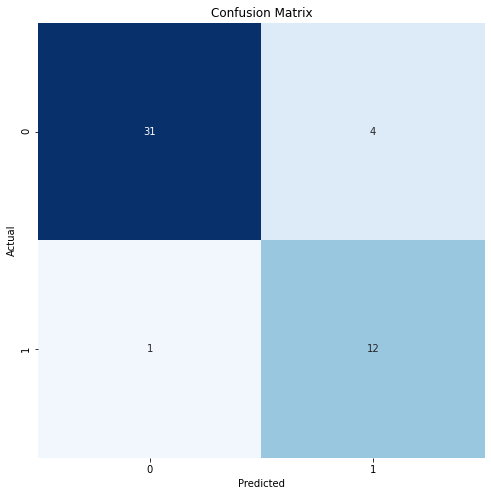

Classification Report:
----------------------
               precision    recall  f1-score   support

         0.0       0.97      0.89      0.93        35
         1.0       0.75      0.92      0.83        13

    accuracy                           0.90        48
   macro avg       0.86      0.90      0.88        48
weighted avg       0.91      0.90      0.90        48



In [18]:
preds1, predsf1 = neurone_modele(train_ds[:,0], donnees_test[:,0])

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 768)]             0         
                                                                 
 tf.expand_dims_20 (TFOpLamb  (None, 768, 1)           0         
 da)                                                             
                                                                 
 gru_20 (GRU)                (None, 768, 256)          198912    
                                                                 
 flatten_20 (Flatten)        (None, 196608)            0         
                                                                 
 dense_20 (Dense)            (None, 3)                 589827    
                                                                 
Total params: 788,739
Trainable params: 788,739
Non-trainable params: 0
____________________________________________________

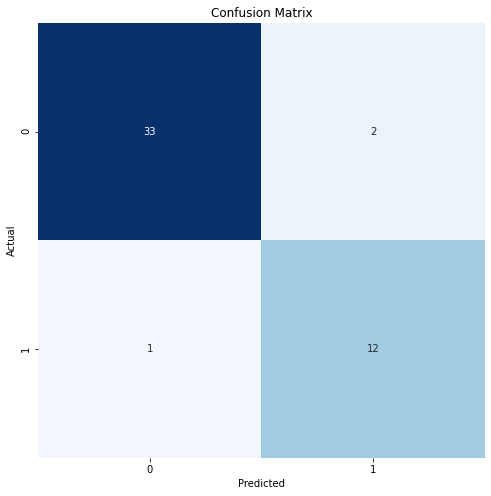

Classification Report:
----------------------
               precision    recall  f1-score   support

         0.0       0.97      0.94      0.96        35
         1.0       0.86      0.92      0.89        13

    accuracy                           0.94        48
   macro avg       0.91      0.93      0.92        48
weighted avg       0.94      0.94      0.94        48



In [111]:
preds2, predsf2 = neurone_modele(train_ds[:,1], donnees_test[:,1])

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 768)]             0         
                                                                 
 tf.expand_dims_5 (TFOpLambd  (None, 768, 1)           0         
 a)                                                              
                                                                 
 gru_5 (GRU)                 (None, 768, 256)          198912    
                                                                 
 flatten_5 (Flatten)         (None, 196608)            0         
                                                                 
 dense_5 (Dense)             (None, 3)                 589827    
                                                                 
Total params: 788,739
Trainable params: 788,739
Non-trainable params: 0
_____________________________________________________

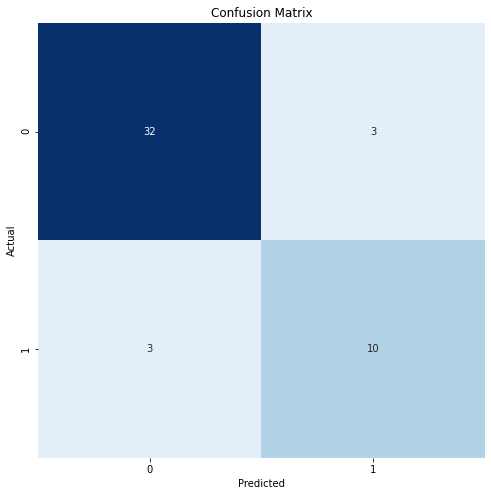

Classification Report:
----------------------
               precision    recall  f1-score   support

         0.0       0.91      0.91      0.91        35
         1.0       0.77      0.77      0.77        13

    accuracy                           0.88        48
   macro avg       0.84      0.84      0.84        48
weighted avg       0.88      0.88      0.88        48



In [20]:
preds3, predsf3 = neurone_modele(train_ds[:,2], donnees_test[:,2])

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 768)]             0         
                                                                 
 tf.expand_dims_6 (TFOpLambd  (None, 768, 1)           0         
 a)                                                              
                                                                 
 gru_6 (GRU)                 (None, 768, 256)          198912    
                                                                 
 flatten_6 (Flatten)         (None, 196608)            0         
                                                                 
 dense_6 (Dense)             (None, 3)                 589827    
                                                                 
Total params: 788,739
Trainable params: 788,739
Non-trainable params: 0
_____________________________________________________

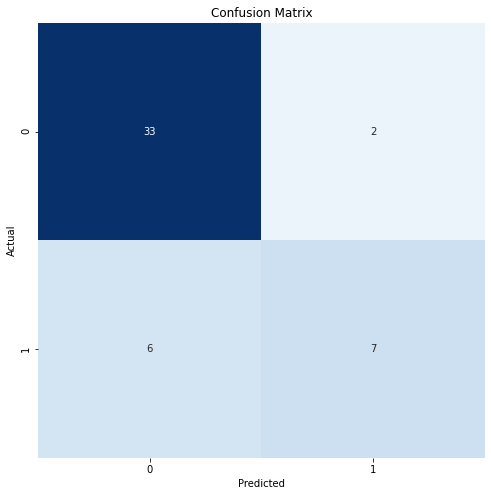

Classification Report:
----------------------
               precision    recall  f1-score   support

         0.0       0.85      0.94      0.89        35
         1.0       0.78      0.54      0.64        13

    accuracy                           0.83        48
   macro avg       0.81      0.74      0.76        48
weighted avg       0.83      0.83      0.82        48



In [21]:
preds4, predsf4 = neurone_modele(train_ds[:,3], donnees_test[:,3])

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 768)]             0         
                                                                 
 tf.expand_dims_7 (TFOpLambd  (None, 768, 1)           0         
 a)                                                              
                                                                 
 gru_7 (GRU)                 (None, 768, 256)          198912    
                                                                 
 flatten_7 (Flatten)         (None, 196608)            0         
                                                                 
 dense_7 (Dense)             (None, 3)                 589827    
                                                                 
Total params: 788,739
Trainable params: 788,739
Non-trainable params: 0
_____________________________________________________

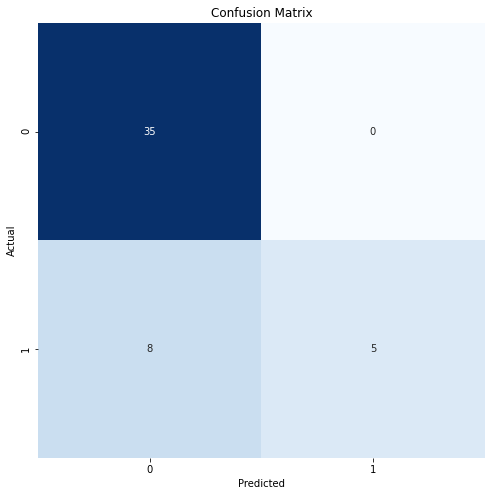

Classification Report:
----------------------
               precision    recall  f1-score   support

         0.0       0.81      1.00      0.90        35
         1.0       1.00      0.38      0.56        13

    accuracy                           0.83        48
   macro avg       0.91      0.69      0.73        48
weighted avg       0.86      0.83      0.80        48



In [22]:
preds5, predsf5 = neurone_modele(train_ds[:,4], donnees_test[:,4])

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 768)]             0         
                                                                 
 tf.expand_dims_19 (TFOpLamb  (None, 768, 1)           0         
 da)                                                             
                                                                 
 gru_19 (GRU)                (None, 768, 256)          198912    
                                                                 
 flatten_19 (Flatten)        (None, 196608)            0         
                                                                 
 dense_19 (Dense)            (None, 3)                 589827    
                                                                 
Total params: 788,739
Trainable params: 788,739
Non-trainable params: 0
____________________________________________________

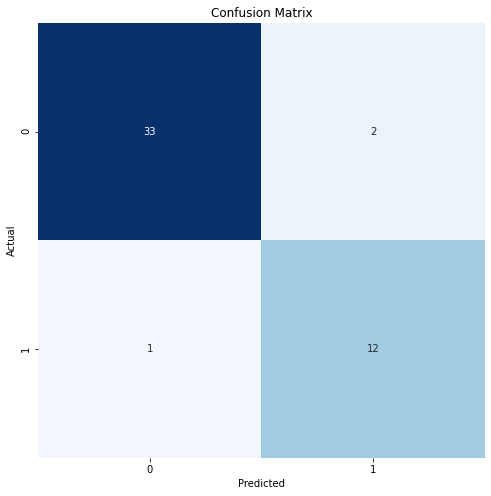

Classification Report:
----------------------
               precision    recall  f1-score   support

         0.0       0.97      0.94      0.96        35
         1.0       0.86      0.92      0.89        13

    accuracy                           0.94        48
   macro avg       0.91      0.93      0.92        48
weighted avg       0.94      0.94      0.94        48



In [110]:
preds6, predsf6 = neurone_modele(np.std(train_ds, axis=1), np.std(donnees_test, axis=1))

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 768)]             0         
                                                                 
 tf.expand_dims_18 (TFOpLamb  (None, 768, 1)           0         
 da)                                                             
                                                                 
 gru_18 (GRU)                (None, 768, 256)          198912    
                                                                 
 flatten_18 (Flatten)        (None, 196608)            0         
                                                                 
 dense_18 (Dense)            (None, 3)                 589827    
                                                                 
Total params: 788,739
Trainable params: 788,739
Non-trainable params: 0
____________________________________________________

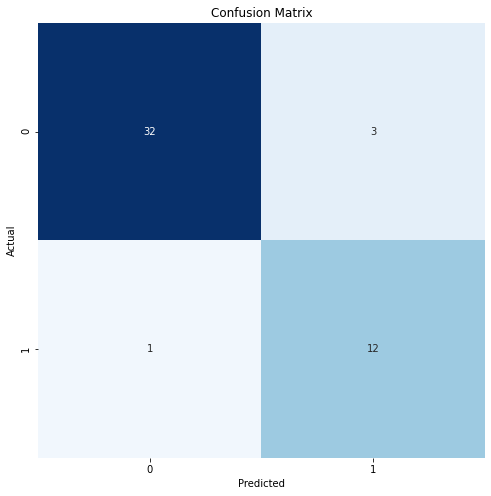

Classification Report:
----------------------
               precision    recall  f1-score   support

         0.0       0.97      0.91      0.94        35
         1.0       0.80      0.92      0.86        13

    accuracy                           0.92        48
   macro avg       0.88      0.92      0.90        48
weighted avg       0.92      0.92      0.92        48



In [108]:
preds7, predsf7 = neurone_modele(np.max(train_ds[:,:1], axis=1), np.max(donnees_test[:,:1], axis=1))

In [112]:
predrnn = np.stack((preds1, preds2,preds3,preds4,preds5,preds6,preds7),axis=1)
predfrnn = np.stack((predsf1, predsf2,predsf3,predsf4,predsf5,predsf6,predsf7),axis=1)

In [109]:
preds6.shape

(4800,)

In [113]:
std_ds =  np.std(train_ds, axis=1).reshape(4800,1,768)
max_ch1_ds = np.max(train_ds[:,:2],axis=2).reshape(4800,1,2)
min_ch1_ds = np.min(train_ds[:,:2],axis=2).reshape(4800,1,2)

new_ds = np.concatenate((train_ds,std_ds), axis=1)

std_test =  np.std(donnees_test, axis=1).reshape(1200,1,768)
new_test = np.concatenate((donnees_test, std_test),axis=1)


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 768)]             0         
                                                                 
 tf.expand_dims_8 (TFOpLambd  (None, 768, 1)           0         
 a)                                                              
                                                                 
 gru_8 (GRU)                 (None, 768, 256)          198912    
                                                                 
 flatten_8 (Flatten)         (None, 196608)            0         
                                                                 
 dense_8 (Dense)             (None, 3)                 589827    
                                                                 
Total params: 788,739
Trainable params: 788,739
Non-trainable params: 0
_____________________________________________________

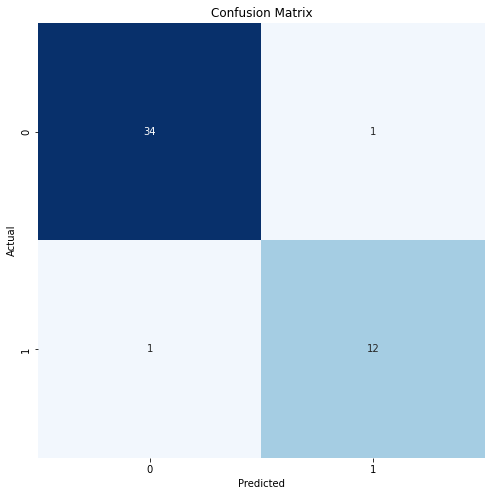

Classification Report:
----------------------
               precision    recall  f1-score   support

         0.0       0.97      0.97      0.97        35
         1.0       0.92      0.92      0.92        13

    accuracy                           0.96        48
   macro avg       0.95      0.95      0.95        48
weighted avg       0.96      0.96      0.96        48

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 768)]             0         
                                                                 
 tf.expand_dims_9 (TFOpLambd  (None, 768, 1)           0         
 a)                                                              
                                                                 
 gru_9 (GRU)                 (None, 768, 256)          198912    
                                                                 
 flatten_9 (Fla

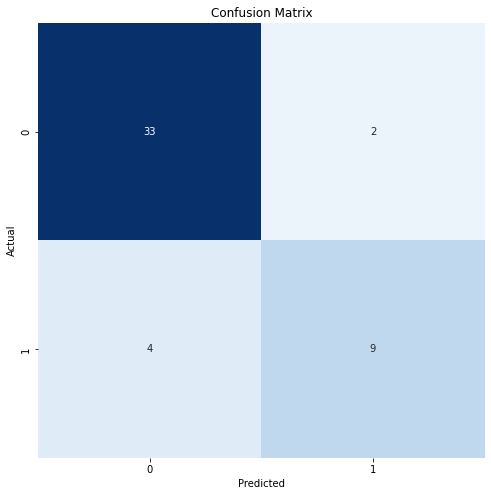

Classification Report:
----------------------
               precision    recall  f1-score   support

         0.0       0.89      0.94      0.92        35
         1.0       0.82      0.69      0.75        13

    accuracy                           0.88        48
   macro avg       0.86      0.82      0.83        48
weighted avg       0.87      0.88      0.87        48

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 768)]             0         
                                                                 
 tf.expand_dims_10 (TFOpLamb  (None, 768, 1)           0         
 da)                                                             
                                                                 
 gru_10 (GRU)                (None, 768, 256)          198912    
                                                                 
 flatten_10 (F

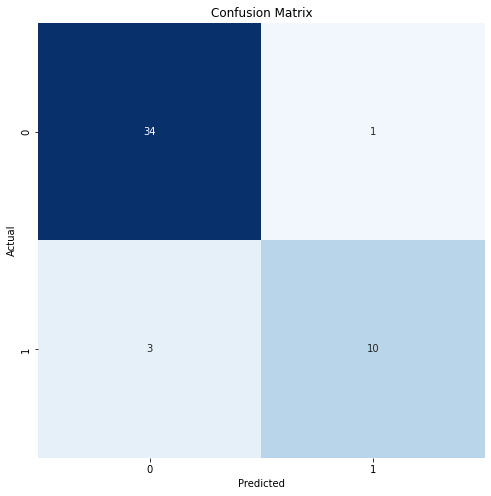

Classification Report:
----------------------
               precision    recall  f1-score   support

         0.0       0.92      0.97      0.94        35
         1.0       0.91      0.77      0.83        13

    accuracy                           0.92        48
   macro avg       0.91      0.87      0.89        48
weighted avg       0.92      0.92      0.91        48

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 768)]             0         
                                                                 
 tf.expand_dims_11 (TFOpLamb  (None, 768, 1)           0         
 da)                                                             
                                                                 
 gru_11 (GRU)                (None, 768, 256)          198912    
                                                                 
 flatten_11 (F

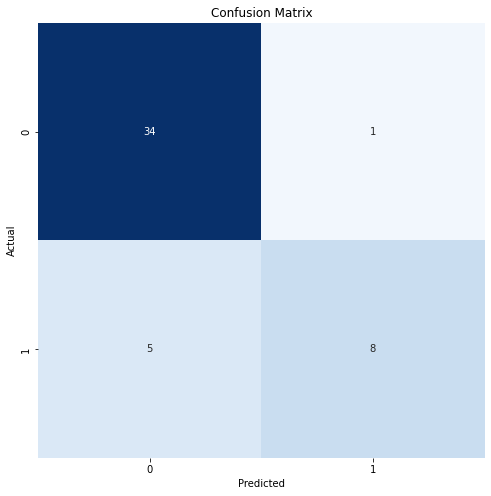

Classification Report:
----------------------
               precision    recall  f1-score   support

         0.0       0.87      0.97      0.92        35
         1.0       0.89      0.62      0.73        13

    accuracy                           0.88        48
   macro avg       0.88      0.79      0.82        48
weighted avg       0.88      0.88      0.87        48

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 768)]             0         
                                                                 
 tf.expand_dims_12 (TFOpLamb  (None, 768, 1)           0         
 da)                                                             
                                                                 
 gru_12 (GRU)                (None, 768, 256)          198912    
                                                                 
 flatten_12 (F

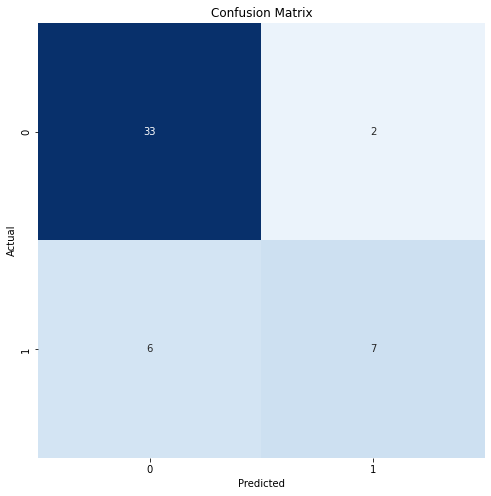

Classification Report:
----------------------
               precision    recall  f1-score   support

         0.0       0.85      0.94      0.89        35
         1.0       0.78      0.54      0.64        13

    accuracy                           0.83        48
   macro avg       0.81      0.74      0.76        48
weighted avg       0.83      0.83      0.82        48

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 768)]             0         
                                                                 
 tf.expand_dims_13 (TFOpLamb  (None, 768, 1)           0         
 da)                                                             
                                                                 
 gru_13 (GRU)                (None, 768, 256)          198912    
                                                                 
 flatten_13 (F

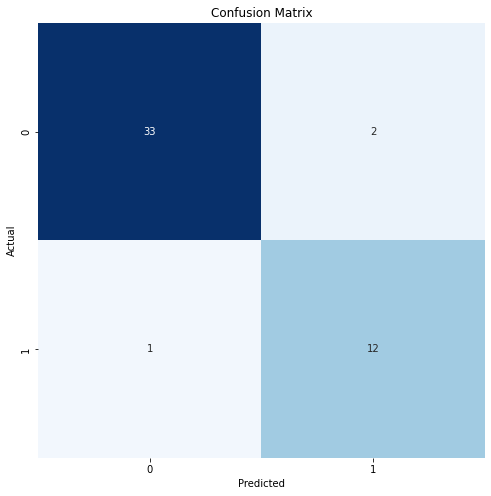

Classification Report:
----------------------
               precision    recall  f1-score   support

         0.0       0.97      0.94      0.96        35
         1.0       0.86      0.92      0.89        13

    accuracy                           0.94        48
   macro avg       0.91      0.93      0.92        48
weighted avg       0.94      0.94      0.94        48

[[1 0 1 1 1 1]
 [1 1 1 1 0 1]
 [1 1 1 1 0 1]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]] (4800, 6)
Le programme a mis 14841.535435199738 s à s'éxecuter


In [ ]:
#Optimisation des modèles pour les cinq canaux (chaque modèle est indépendant) SMOTE
def model_prediction(X, Y, Z):
    splitted_models = []
    listePrediction = []
    listePredictionFinales = []

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

    params = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50,100,200]}

    model = neurone_modele
    grid = GridSearchCV(model, {"n_estimators":[50,75,100], "max_features":[0.5,0.75,'auto']})
    #grid = RandomizedSearchCV(RandomForestClassifier(), param_distributions= params, n_iter = 10, cv = 4, verbose=2, random_state=42, n_jobs = -1)
    for i in range(6):
        #X_train_smote, y_train_smote= smote.fit_resample(X[:,i], Y)
        pred, predF = model(X[:,i],Y, Z[:,i])

        listePrediction.append(pred)
        listePredictionFinales.append(predF)
        

    listePrediction = (np.array(listePrediction)).T
    print(listePrediction, listePrediction.shape)

    return (listePrediction, listePredictionFinales)

t1 = time.time()
predictions, modeles_canaux = model_prediction(new_ds, train_labels, new_test)
t2 = time.time()
print(f"Le programme a mis {t2-t1} s à s'éxecuter")

In [149]:
#Optimisation des modèles pour les cinq canaux (chaque modèle est indépendant) SMOTE
def model_predictionz(X, Y):
    splitted_models = []
    listePrediction = []

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

    params = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50,100,200]}

    model = RandomForestClassifier(n_estimators=80)
    grid = GridSearchCV(model,{})
    #grid = RandomizedSearchCV(RandomForestClassifier(), param_distributions= params, n_iter = 10, cv = 4, verbose=2, random_state=42, n_jobs = -1)
    for i in range(6):
        #X_train_smote, y_train_smote= smote.fit_resample(X[:,i], Y)
        grid.fit(X[:,i],Y)
        splitted_models.append(grid.best_estimator_)

        print(f"Performance sur le canal {i+1} : {splitted_models[i].score(X_test[:,i], Y_test)}")
        print("infos : ",grid.best_params_, grid.best_score_)
        ypred = splitted_models[i].predict(X_test[:,i])
        print(confusion_matrix(Y_test, ypred))
        print(classification_report(Y_test, ypred))

        listePrediction.append( splitted_models[i].predict_proba(X[:,i])[:,1] )
        print(listePrediction, len(listePrediction))


    listePrediction = (np.array(listePrediction)).T
    print(listePrediction, listePrediction.shape)

    return (listePrediction, splitted_models)

t1 = time.time()
predictions2, modeles_canaux2 = model_predictionz(new_ds, train_labels)
t2 = time.time()
print(f"Le programme a mis {t2-t1} s à s'éxecuter")

Performance sur le canal 1 : 1.0
infos :  {} 0.9397916666666667
[[1008    0]
 [   0  192]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1008
         1.0       1.00      1.00      1.00       192

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200

[array([0.8625, 1.    , 0.9375, ..., 0.    , 0.025 , 0.    ])] 1
Performance sur le canal 2 : 1.0
infos :  {} 0.9427083333333333
[[1008    0]
 [   0  192]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1008
         1.0       1.00      1.00      1.00       192

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200

[array([0.8625, 1.    , 0.9375, ..., 0.    , 0.025 , 0.    ]), array([0.775 , 1.    , 0.9125, ..., 

In [139]:
#Modèle d'assemblage des données
def merge_channels(X, Y, modele, params):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.001)
    #X_train_smote, y_train_smote= smote.fit_resample(X_train, Y_train)


    grid = GridSearchCV(modele, param_grid=params, cv=5)
    grid.fit(X,Y)
    modele = (grid.best_estimator_)
    print("infos : ",grid.best_params_, grid.best_score_)
    print(f"Performance sur l'assembleur : {modele.score(X_test, Y_test)}")
    ypred = modele.predict(X_test)
    print(confusion_matrix(Y_test, ypred))
    print(classification_report(Y_test, ypred))

    return modele

param_svc={'C':[0.1,0.25, 0.5], 'gamma':[0.01,0.1,0.001,0.0001], 'kernel':['rbf','linear'] }
param_knn={'n_neighbors':np.arange(5,50,5)}
parameter_space = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive']
}


listeModeles = [(SVC(),param_svc),
                (SVC(), {}),
                (MLPClassifier(),{}),
                (RandomForestClassifier(),{})           
                ]
m =[]
s=[]
for model in listeModeles:
    m.append(merge_channels(predrnn, train_labels, model[0],model[1]))
#    s.append(merge_channels(predictions2, train_labels, model[0],model[1]))

modele_assembleur = m[0]


infos :  {'C': 0.25, 'gamma': 0.1, 'kernel': 'rbf'} 0.9852083333333332
Performance sur l'assembleur : 1.0
[[4 0]
 [0 1]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         4
         1.0       1.00      1.00      1.00         1

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5

infos :  {} 0.9824999999999999
Performance sur l'assembleur : 0.8
[[3 1]
 [0 1]]
              precision    recall  f1-score   support

         0.0       1.00      0.75      0.86         4
         1.0       0.50      1.00      0.67         1

    accuracy                           0.80         5
   macro avg       0.75      0.88      0.76         5
weighted avg       0.90      0.80      0.82         5

infos :  {} 0.9852083333333332
Performance sur l'assembleur : 1.0
[[4 0]
 [0 1]]
              precision    recall  f1-score   support

        

In [151]:
#Reconstruction de la sortie des cinq modèles en un np.array qu'utilisera le modèle d'assemblage
def predict_splitted_score(X, models):
    listePrediction = []

    for i in range(6):
        
        listePrediction.append(models[i].predict_proba(X[:,i])[:,1])

    listePrediction = np.array(listePrediction).T
    return listePrediction

In [100]:
def construction_sociale(listePred):
  apolito = []
  for x in listePred:
    if np.sum(x) >= 2.15:
      apolito.append(1)
    else:
      apolito.append(0)

  return apolito


def assemblage_modele(l1, l2):
  sortie=[]
  for i in range(len(l1)):
    if l1[i]==1 or l2[i]==1:
      sortie.append(1)
    else:
      sortie.append(0)
  return sortie

def aassemblage_modele(l1, l2):
  sortie=[]
  for i in range(len(l1)):
    if l1[i]==1 and l2[i]==1:
      sortie.append(1)
    else:
      sortie.append(0)
  return sortie

import math

def somo(prediction):
  l = []
  for elem in prediction:
    c=0
    for x in elem:
      if x==1:
        c+=1

    if c>=3:
      dixo=1
    else:
      dixo=0
    l.append(dixo)

  return np.array(l)

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 13)]              0         
                                                                 
 tf.expand_dims_24 (TFOpLamb  (None, 13, 1)            0         
 da)                                                             
                                                                 
 gru_24 (GRU)                (None, 13, 256)           198912    
                                                                 
 flatten_24 (Flatten)        (None, 3328)              0         
                                                                 
 dense_24 (Dense)            (None, 3)                 9987      
                                                                 
Total params: 208,899
Trainable params: 208,899
Non-trainable params: 0
____________________________________________________

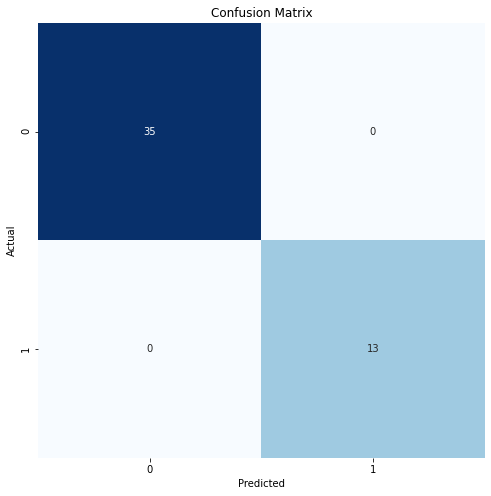

Classification Report:
----------------------
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        35
         1.0       1.00      1.00      1.00        13

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



In [154]:
paz = np.concatenate((predfrnn,predict_splitted_score(new_test, modeles_canaux2)),axis=1)
aze, boze = neurone_modele(np.concatenate((predrnn,predictions2),axis=1),paz, epo=35)

In [160]:

t1 = time.time()
#total_test = np.concatenate((donnees_test,extract_features(donnees_test)), axis=2)
#feature_extract = np.concatenate((predict_splitted_score(donnees_test, modeles_canaux), predict_splitted_score(donnees_test, modeles_canaux2)[:,:2]), axis=1)
#feature_extract = predict_splitted_score(np.concatenate((donnees_test, np.std(donnees_test, axis=1).reshape(1200,1,768)), axis=1), modeles_canaux)

#feature_extract = predict_splitted_score(donnees_test, modeles_canaux)
predou = []
#for mod in m:
#  i=0
#  predou.append(mod.predict(feature_extract))

#predou = np.array(predou).reshape(1200,6)


#abou = somo(predou)
bas = predfrnn
abou = assemblage_modele(
    assemblage_modele( 
        m[1].predict(bas).astype(int),m[3].predict(bas).astype(int)),
        assemblage_modele( m[1].predict(bas).astype(int) ,assemblage_modele( boze.astype(int), m[1].predict(bas).astype(int))))
sortie = pd.Series(abou)
#sortie = pd.Series(modele_principal.predict(donnees_test.reshape(1200,768*5)))
nombre_un = len(sortie[sortie==1])
print(f"Number of 1  :    {nombre_un}")
print(f"Max précision : {(1000+nombre_un)/1200}")
print(sortie)
sortie.to_csv("rendu.csv",header=["Id,Outcome"])
t2=time.time()
print(f"Le programme a mis {t2-t1} s à s'éxecuter")

with open('rendu.csv', 'r') as file:
    # read a list of lines into data
    data = file.readlines()

# now change the 2nd line, note that you have to add a newline
data[0] = 'Id,Outcome\n'

# and write everything back
with open('rendu.csv', 'w') as file:
    file.writelines( data )

Number of 1  :    189
Max précision : 0.9908333333333333
0       1
1       0
2       0
3       0
4       0
       ..
1195    0
1196    0
1197    0
1198    0
1199    0
Length: 1200, dtype: int64
Le programme a mis 0.12267374992370605 s à s'éxecuter


In [ ]:
#Tests de performances sur canal
def canal(X, Y, i, modele, params):
    print(f"Canal {i+1} modèle {modele}")
    X_train, X_test, Y_train, Y_test = train_test_split(X[:,i], Y, test_size=0.25)
    
    grid = GridSearchCV(modele, param_grid=params, cv=8)
    grid.fit(X_train,Y_train)
    modele = (grid.best_estimator_)
    print("infos : ",grid.best_params_, grid.best_score_)
    print(f"Performance sur le canal {i+1} : {modele.score(X_test, Y_test)}")
    ypred = modele.predict(X_test)
    print(confusion_matrix(Y_test, ypred))
    print(classification_report(Y_test, ypred))

    #N, train_score, val_score = learning_curve(modele, X_train, Y_train,
    #                                          cv=4, scoring='f1',
    #                                           train_sizes=np.linspace(0.1, 1, 10))
    
    
    #plt.figure(figsize=(12, 8))
    #plt.plot(N, train_score.mean(axis=1), label='train score')
    #plt.plot(N, val_score.mean(axis=1), label='validation score')
    #plt.legend()
    return 1


param_svc={}
param_mlp={}
listeModeles = [#(SVC(), {'C':[0.5,1.0,10.0]}),
                (RandomForestClassifier(), {'n_estimators':[100,150]})
                ]


for i in listeModeles:
    canal(train_ds, train_labels, 1, i[0],i[1])


Canal 2 modèle RandomForestClassifier()
infos :  {'n_estimators': 100} 0.9505555555555555
Performance sur le canal 2 : 0.9575
[[991  19]
 [ 32 158]]
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      1010
         1.0       0.89      0.83      0.86       190

    accuracy                           0.96      1200
   macro avg       0.93      0.91      0.92      1200
weighted avg       0.96      0.96      0.96      1200



In [ ]:
a = MLPClassifier().fit(train_ds[:,1], train_labels).predict(train_ds[:,1])
print(classification_report(train_labels,a))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2000
         1.0       0.98      0.98      0.98       400

    accuracy                           0.99      2400
   macro avg       0.99      0.99      0.99      2400
weighted avg       0.99      0.99      0.99      2400

